Here we will try to predict price of the diamond using 17 features

Link to kaggle: <https://www.kaggle.com/datasets/beridzeg45/diamonds-prices-prediction/data>

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

RANDOM_STATE = 777
random.seed(RANDOM_STATE)

df = pd.read_csv('diamonds (cleaned).csv')
df.head(5)

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence
0,Cushion Modified,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,NaN,7.09,6.95,4.57,2640,GIA Lab-Grown,NaN
1,Pear,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,NaN,9.64,5.86,3.66,1070,GIA Lab-Grown,NaN
2,Oval,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,NaN,8.44,6.00,3.79,1070,GIA Lab-Grown,NaN
3,Heart,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,NaN,5.85,6.89,4.25,7110,GIA,Faint
4,Radiant,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,NaN,6.80,5.05,3.50,3050,GIA,NaN


Firstly lets see info

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6485 entries, 0 to 6484
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Shape               6480 non-null   object 
 1   Cut                 2182 non-null   object 
 2   Color               6480 non-null   object 
 3   Clarity             6480 non-null   object 
 4   Carat Weight        6480 non-null   float64
 5   Length/Width Ratio  6480 non-null   float64
 6   Depth %             6478 non-null   float64
 7   Table %             6468 non-null   float64
 8   Polish              6465 non-null   object 
 9   Symmetry            6465 non-null   object 
 10  Girdle              6463 non-null   object 
 11  Culet               1891 non-null   object 
 12  Length              6465 non-null   float64
 13  Width               6465 non-null   float64
 14  Height              6465 non-null   float64
 15  Price               6485 non-null   int64  
 16  Type  

In [63]:
df.isna().sum()

Shape                    5
Cut                   4303
Color                    5
Clarity                  5
Carat Weight             5
Length/Width Ratio       5
Depth %                  7
Table %                 17
Polish                  20
Symmetry                20
Girdle                  22
Culet                 4594
Length                  20
Width                   20
Height                  20
Price                    0
Type                     0
Fluorescence          5264
dtype: int64

As wee can see, there are 3 categories, where NaN values dominate other categories: Cut, Culet and Fluorescence. Let's calculate Kramer's correlation between all these features; between each of them and Price

In [64]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = sum(confusion_matrix.sum())
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

features = ['Cut', 'Culet', 'Fluorescence']
for i in range(len(features)):
    for j in range(i):
        print(f"{features[i], features[j], cramers_v(df[features[i]], df[features[j]])}")
print()
for i in features:
     print(f"{i, 'Price', cramers_v(df[i], df.Price)}")

('Culet', 'Cut', np.float64(0.8933195408028406))
('Fluorescence', 'Cut', np.float64(0.18555627767058733))
('Fluorescence', 'Culet', np.float64(0.4906533814626582))

('Cut', 'Price', np.float64(0.6994347710864145))
('Culet', 'Price', np.float64(0.9052153559717191))
('Fluorescence', 'Price', np.float64(0.5855121948458868))


As wee can notice, Cut and Culet are important for prediction. Fluorescence less, but also have correlation with price. Now lets find number of unique labels of each feature

In [65]:
cnt = 0
categorical_features = df.select_dtypes(include=['object']).columns
for i in features:
    print(i, len(df[i].value_counts().unique()))
    cnt += len(df[i].value_counts().unique())
cnt

Cut 4
Culet 4
Fluorescence 3


11

Not much. It means that we can use OHE for encoding data.
And I decided to make additional label "Not Given" for Cut, Culet and Fluorescence and fill all NaN with such label. Because NaN dominates and filling with most popular label is not good idea. Okay, lets fill NaN.

In [66]:

df.Price = df.Price.astype('float64')
numeric_features = df.select_dtypes(include=['number']).columns
numeric_features = numeric_features.drop('Price')

categorical_values = {i: df[i].mode()[0] for i in categorical_features}
categorical_values['Cut'] = 'Not Given'
categorical_values['Culet'] = 'Not Given'
categorical_values['Fluorescence'] = 'Not Given'

numeric_values = df[numeric_features].median()

df.fillna(categorical_values, inplace=True)
df.fillna(numeric_values, inplace=True)

df.isna().sum()

Shape                 0
Cut                   0
Color                 0
Clarity               0
Carat Weight          0
Length/Width Ratio    0
Depth %               0
Table %               0
Polish                0
Symmetry              0
Girdle                0
Culet                 0
Length                0
Width                 0
Height                0
Price                 0
Type                  0
Fluorescence          0
dtype: int64

In [67]:
df.sample(10)

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence
2360,Pear,Not Given,E,VS2,1.01,1.60,58.8,55.0,Excellent,Excellent,Thick to Very Thick,Not Given,8.92,5.58,3.29,4870.0,GIA,Faint
3873,Radiant,Not Given,F,VS2,1.02,1.30,68.2,66.0,Excellent,Excellent,Slightly Thick to Thick,Not Given,6.56,5.04,3.44,3990.0,GIA,Not Given
1970,Oval,Not Given,D,VS1,1.01,1.66,62.5,63.0,Excellent,Very Good,Slightly Thick to Very Thick,Not Given,8.79,5.31,3.32,4820.0,GIA,Not Given
3584,Pear,Not Given,E,VS2,1.00,1.48,64.9,56.0,Excellent,Very Good,Medium to Very Thick,Not Given,8.25,5.59,3.63,4400.0,GIA,Not Given
5106,Pear,Not Given,E,VS1,1.08,1.64,60.8,58.0,Excellent,Excellent,Thin to Medium,Pointed,9.47,5.77,3.51,1090.0,IGI Lab-Grown,Not Given
3751,Marquise,Not Given,G,VVS1,1.02,1.98,60.9,58.0,Excellent,Excellent,Slightly Thick to Thick,Not Given,10.34,5.22,3.18,4687.0,GIA,Medium
3720,Round,Excellent,F,VS1,1.56,1.01,61.5,60.0,Excellent,Excellent,Medium to Slightly Thick,Not Given,7.41,7.45,4.57,1830.0,GIA Lab-Grown,Not Given
6176,Heart,Not Given,E,VVS2,1.01,1.14,58.8,58.0,Excellent,Very Good,Slightly Thick to Very Thick,Not Given,6.04,6.91,4.06,3690.0,GIA,Medium
3595,Cushion,Ideal,D,VS1,1.91,1.02,66.2,60.0,Excellent,Excellent,Medium to Slightly Thick,Pointed,7.28,7.13,4.72,5310.0,IGI Lab-Grown,Not Given
3916,Pear,Not Given,F,VS1,1.00,1.45,65.6,57.0,Excellent,Good,Slightly Thick to Very Thick,Not Given,8.00,5.51,3.62,3890.0,GIA,Not Given


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6485 entries, 0 to 6484
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Shape               6485 non-null   object 
 1   Cut                 6485 non-null   object 
 2   Color               6485 non-null   object 
 3   Clarity             6485 non-null   object 
 4   Carat Weight        6485 non-null   float64
 5   Length/Width Ratio  6485 non-null   float64
 6   Depth %             6485 non-null   float64
 7   Table %             6485 non-null   float64
 8   Polish              6485 non-null   object 
 9   Symmetry            6485 non-null   object 
 10  Girdle              6485 non-null   object 
 11  Culet               6485 non-null   object 
 12  Length              6485 non-null   float64
 13  Width               6485 non-null   float64
 14  Height              6485 non-null   float64
 15  Price               6485 non-null   float64
 16  Type  

Now we have 2 ways. For using Random Forest and Boosting, better way to choose Ordinal Encoding. For Linear Model and SVM, I'll choose One-Hot encoding.

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6485 entries, 0 to 6484
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Shape               6485 non-null   object 
 1   Cut                 6485 non-null   object 
 2   Color               6485 non-null   object 
 3   Clarity             6485 non-null   object 
 4   Carat Weight        6485 non-null   float64
 5   Length/Width Ratio  6485 non-null   float64
 6   Depth %             6485 non-null   float64
 7   Table %             6485 non-null   float64
 8   Polish              6485 non-null   object 
 9   Symmetry            6485 non-null   object 
 10  Girdle              6485 non-null   object 
 11  Culet               6485 non-null   object 
 12  Length              6485 non-null   float64
 13  Width               6485 non-null   float64
 14  Height              6485 non-null   float64
 15  Price               6485 non-null   float64
 16  Type  

**Part 1. Boosting and Random Forest**

In [70]:
from sklearn.model_selection import train_test_split

X, y = df.drop(columns='Price'), df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [71]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

column_transformer_ordinal = ColumnTransformer(
    [('OrdinalEncoding', OrdinalEncoder(handle_unknown='error'), categorical_features)], 
    remainder='passthrough')

X_train = column_transformer_ordinal.fit_transform(X_train, y_train).astype(np.float64)
X_test = column_transformer_ordinal.transform(X_test).astype(np.float64)

*RandomForest*

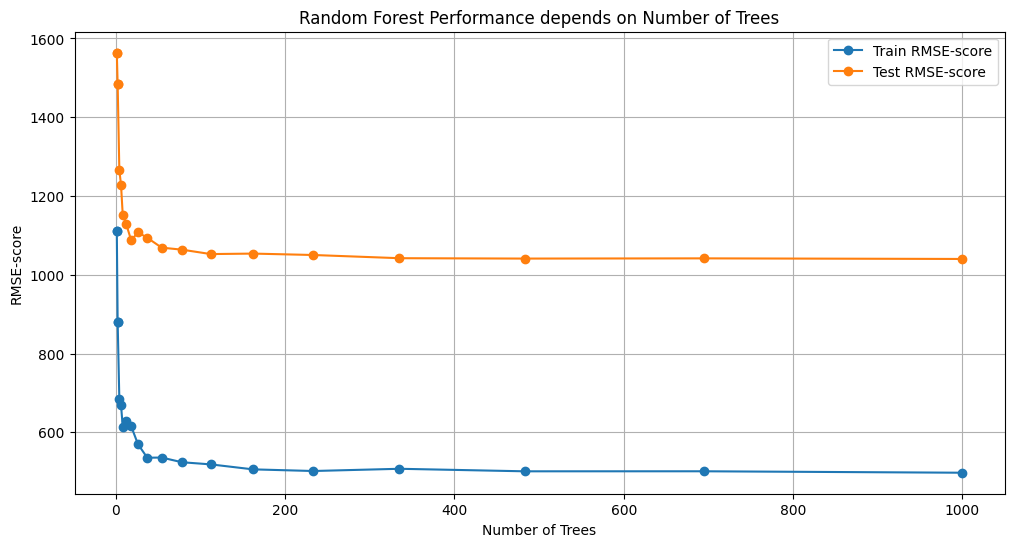

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error as rmse


params = list(map(np.int64, np.logspace(0, 3, 20)))

train_rmse_scores = []
test_rmse_scores = []

for n_trees in params:
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=RANDOM_STATE)
    rf.fit(X_train, y_train)
    
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    train_rmse = rmse(y_train, y_train_pred)
    test_rmse = rmse(y_test, y_test_pred)
    
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)

plt.figure(figsize=(12, 6))
plt.plot(params, train_rmse_scores, label='Train RMSE-score', marker='o')
plt.plot(params, test_rmse_scores, label='Test RMSE-score', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE-score')
plt.title('Random Forest Performance depends on Number of Trees')
plt.legend()
plt.grid()
plt.show()

In [73]:
id = train_rmse_scores.index(min(train_rmse_scores))
print(f"Number of trees: {params[id]}")
print(f"Train rmse min: {train_rmse_scores[id]}")
print(f"Test rmse: {test_rmse_scores[id]}")

id = test_rmse_scores.index(min(test_rmse_scores))
print(f"Number of trees: {params[id]}")
print(f"Train rmse min: {train_rmse_scores[id]}")
print(f"Test rmse: {test_rmse_scores[id]}")

Number of trees: 1000
Train rmse min: 497.41343997099546
Test rmse: 1040.147638155296
Number of trees: 1000
Train rmse min: 497.41343997099546
Test rmse: 1040.147638155296


In [74]:
model = RandomForestRegressor(n_estimators=1000, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.8650746068853646


Finally, for RandomForest we have rooted mean squared error for train data: 497.41343997099546, for test_data: 1040.147638155296.

**Score: 0.8650746068853646**

*Boosting*

In [75]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

train_rmse = rmse(y_train, y_train_pred)
test_rmse = rmse(y_test, y_test_pred)

print(train_rmse, test_rmse)
print(xgb_model.score(X_test, y_test))

255.91156749248952 1050.8570715871854
0.8622819008457401


For XGBoost Regressor we have rooted mean squared error for train data: 255.91156749248952, for test_data: 1050.8570715871854.

**Score: 0.8622819008457401**

Now lets go for Linear Regressor and SVR. Don't forget that now we should use One-Hot-Encoder and StandardScaler

***Part 2. Linear Regression and SVM***

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

column_transformer_ohe = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
     ('scaled', StandardScaler(), numeric_features)])
X_train = column_transformer_ohe.fit_transform(X_train, y_train).astype(np.float64)
X_test = column_transformer_ohe.transform(X_test).astype(np.float64)

*Linear Regression*

In [77]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_rmse = rmse(y_train, y_train_pred)
test_rmse = rmse(y_test, y_test_pred)

print(train_rmse, test_rmse)
print(lr.score(X_test, y_test))

1772.9605063255447 1471.9099905480703
0.7298118960250517


Native Linear Regression have rmse on train data: 1772.9605063255447, rmse on test data: 1471.9099905480703

**Score: 0.7298118960250517**

In [78]:
lasso = Lasso()
params = {'alpha' : np.logspace(0, 1, 50)}
grid_search = GridSearchCV(lasso, params, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_rmse = rmse(y_train, y_train_pred)
test_rmse = rmse(y_test, y_test_pred)

print(f"Best alpha: {best_alpha}")
print(train_rmse, test_rmse)
print(lr.score(X_test, y_test))

/Users/opyat-ne-zavoditsya/hse/code/pr/ml/Will_hw/option1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 503551229.4281597, tolerance: 4556019.570701208
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/opyat-ne-zavoditsya/hse/code/pr/ml/Will_hw/option1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120111839.05504227, tolerance: 4747399.0199491335
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/opyat-ne-zavoditsya/hse/code/pr/ml/Will_hw/option1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549838158.792839, tolerance: 45560

Best alpha: 2.2229964825261948
1787.4629948598897 1478.2353512953937
0.7298118960250517


Lasso results: rmse on train 1787.4629948598897, rmse on test 1478.2353512953937

**Score: 0.7298118960250517**

In [79]:
ridge = Ridge()
params = {'alpha' : np.logspace(0, 1, 50)}
grid_search = GridSearchCV(ridge, params, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_rmse = rmse(y_train, y_train_pred)
test_rmse = rmse(y_test, y_test_pred)

print(f"Best alpha: {best_alpha}")
print(train_rmse, test_rmse)
print(lr.score(X_test, y_test))

Best alpha: 4.498432668969445
1784.1433499561033 1469.379184523705
0.7298118960250517


Ridge results: rmse on train 1784.1433499561033, rmse on test 1469.379184523705

**Score: 0.7298118960250517**

*SVM*

In [80]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

train_rmse = rmse(y_train, y_train_pred)
test_rmse = rmse(y_test, y_test_pred)

print(train_rmse, test_rmse)
print(svr.score(X_test, y_test))

3325.377136418297 2743.7954101932137
0.06112631196340568


And last model, Supported Vector, has terrible result: rmse on train data 3325.377136418297, rmst on test data 2743.7954101932137. It means that this model doens't fit to our task.

**Score: 0.06112631196340568**

***Conclusion***

In conclusion lets compare all models we used and sort them by descending of the score value.

1) Random Forest: 0.8650746068853646
2) XGBoost: 0.8622819008457401
3) Native Linear Regression: 0.7298118960250517
4) Lasso: 0.7298118960250517
5) Ridge: 0.7298118960250517
6) SVR: 0.06112631196340568

We can notice that best model 2 model for our task with almost the same score are Random Forest and Boosting from XGBoost. All of them have error about 1040-1050 of currency. But actually differs on train data: 497 for Forest and 255 for Boosting. It means that XGBoost better understood train data than Random Forest.
Not lets see different statistics about the Price

In [81]:
y.describe()

count     6485.000000
mean      3529.391365
std       3280.439167
min       1010.000000
25%       1210.000000
50%       3320.000000
75%       4390.000000
max      39460.000000
Name: Price, dtype: float64

Mean is 3529, median is 3320, our error is 1050. It's not so bad, but I think, if we remove strings where price is large, the score will become better.